In [ ]:
!pip install transformers torch huggingface_hub pyexiv2

In [ ]:
!pip install diffusers

In [ ]:
from diffusers import(
    StableDiffusionPipeline,
    DPMSolverMultistepScheduler,
)
import transformers
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
from huggingface_hub import hf_hub_download,login
import gc

In [ ]:
login(token="hf_token")

HF

In [ ]:
checkpoint_repo = "finnstrom3693/aingd-v8-sd-1.5"

In [ ]:
checkpoint_repo = "finnstrom3693/mistoon-v2-sd-1.5"

In [ ]:
checkpoint_repo = "nqzfaizal77ai/austersight-exp-sd-1.5"

Civit AI

Meinamix 12

In [ ]:
!curl -L -o meinamix12-sd-1.5.safetensors -H "Authorization: Bearer civit_ai_token" "https://civitai.com/api/download/models/948574?type=Model&format=SafeTensor&size=pruned&fp=fp16"

In [ ]:
model = "meinamix12-sd-1.5.safetensors"

In [ ]:
!curl -L -o meinamix12-sd-1.5-vae.safetensors -H "Authorization: Bearer civit_ai_token" "https://civitai.com/api/download/models/948574?type=VAE&format=SafeTensor"

In [ ]:
vae = "meinamix12-sd-1.5-vae.safetensors"

Model Processing

In [ ]:
precision = 'half' # @param ["half", "full" ,"bf16"]
if precision == "half":
    selected_precision = torch.float16
elif precision == "full":
    selected_precision = torch.float32
elif precision == "bf16":
    selected_precision = torch.bfloat16

In [ ]:
# Load Model From Huggingface
pipe = StableDiffusionPipeline.from_pretrained(checkpoint_repo,
                                            torch_dtype=selected_precision,
                                            use_safetensors=True)

In [ ]:
# Load From File
pipe = StableDiffusionPipeline.from_single_file(model,
                                            torch_dtype=selected_precision,
                                            use_safetensors=True)

In [ ]:
# Load From File Using Vae
from diffusers import AutoencoderKL
vae = AutoencoderKL.from_single_file(vae,
                                     torch_dtype=selected_precision,
                                     use_safetensors=True)

pipe = StableDiffusionPipeline.from_single_file(model,
                                            torch_dtype=selected_precision,
                                            use_safetensors=True,
                                            vae=vae)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
pipe.to(device)
pipe.safety_checker = None
pipe.requires_safety_checker = False
DPMSolverMultistepScheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(
    pipe.scheduler.config,
    algorithm_type="sde-dpmsolver++",
    use_karras_sigmas=True
)

Inference

In [ ]:
# @title Inference Settings

prompt = "1girl, student, white shirt, light blue necktie matching a light blue skirt, single left breast pocket, curious expression,brown hair,short wavy hair, chest to head shot, surrounded by bookshelves, warm ambient light, scattered books, peaceful atmosphere, anime style, high quality, detailed" # @param {type:"string"}
negative_prompt = "lowres,double pocket,necktie and skirt color not match,text,error,cropped,worst quality,low quality,jpeg artifacts,ugly,duplicate,morbid,mutilated,out of frame,extra fingers,mutated hands,poorly drawn hands,poorly drawn face,mutation,deformed,blurry,dehydrated,bad anatomy,bad proportions,extra limbs,cloned face,disfigured,gross proportions,malformed limbs,missing arms,missing legs,extra arms,extra legs,fused fingers,too many fingers,long neck,username,watermark,signature" # @param {type:"string"}
orientation = 'portrait' # @param ["portrait", "square", "landscape","square768"]
# Set width and height based on orientation
if orientation == 'portrait':
    width = 512 # Example width for portrait
    height = 768 # Example height for portrait
elif orientation == 'square':
    width = 512 # Example width for square
    height = 512 # Example height for square
elif orientation == 'landscape':
    width = 768 # Example width for landscape
    height = 512 # Example height for landscape
elif orientation == 'square768':
    width = 768 # Example width for square
    height = 768 # Example height for square
size=str(width)+"x"+str(height)
cfg_scale = 8 # @param {type:"integer"}
steps = 20 # @param {type:"integer"}
sampler = "DPM++ SDE Karras" # @param {type:"string"}
modelname = "mistoon-v2" # @param {type:"string"}

In [ ]:
# Random Inference
import random

manual_seed = random.randint(1,999999)
print("seed :",manual_seed)
generator = torch.Generator(device="cuda").manual_seed(manual_seed)
images = pipe(
            prompt = prompt,
            negative_prompt = negative_prompt,
            width = width,
            height = height,
            guidance_scale = cfg_scale,
            num_inference_steps = steps,
            num_images_per_prompt = 4,
            generator = generator
        ).images

seed : 485030


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# # Fixed Inference
# manual_seed = 3277
# print("seed :",manual_seed)
# generator = torch.Generator(device=device).manual_seed(manual_seed)
# images = pipe(
#             prompt = prompt,
#             negative_prompt = negative_prompt,
#             width = width,
#             height = height,
#             guidance_scale = cfg_scale,
#             num_inference_steps = steps,
#             num_images_per_prompt = 4,
#             generator = generator
#         ).images

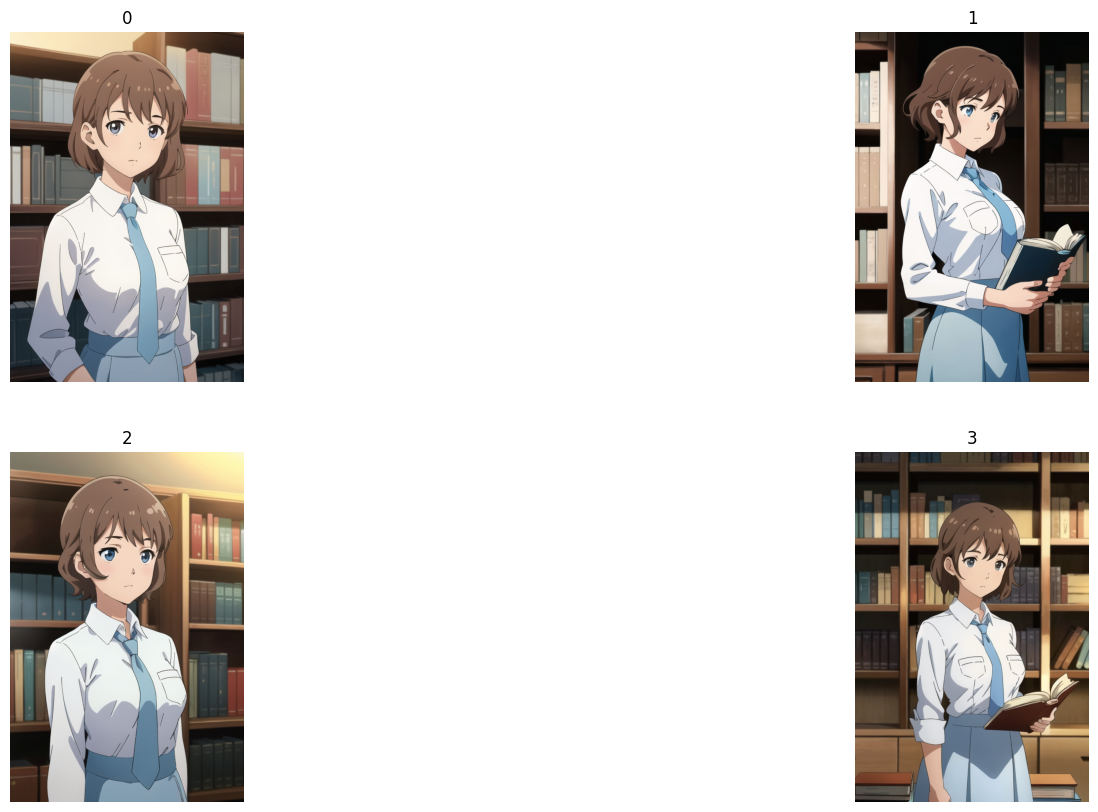

In [ ]:
def plot_images(images):
    N = len(images)
    n_cols = 2
    n_rows = int(np.ceil(N / n_cols))

    plt.figure(figsize = (20, 5 * n_rows))
    for i in range(len(images)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.title(i)
        plt.imshow(np.array(images[i]))
        plt.axis(False)
    plt.show()
plot_images(images)

Save and Write Metadata

In [ ]:
import pyexiv2
import json
import os

def get_unique_filename(base_name, ext):
    """Generate a unique filename by appending a numeric suffix if necessary."""
    counter = 1
    unique_name = f"{base_name}{ext}"
    while os.path.exists(unique_name):
        unique_name = f"{base_name}_{counter}{ext}"
        counter += 1
    return unique_name

for i in range(len(images)):
    # Save image with unique filename
    base_filename = f"image{i}"
    ext = ".png"
    unique_filename = get_unique_filename(base_filename, ext)
    images[i].save(unique_filename)

    metadata_diffusers = {
        "prompt": prompt,
        "negativePrompt": negative_prompt,
        "steps": steps,
        "samplerName": sampler,
        "cfgScale": cfg_scale,
        "seed": manual_seed,
        "clipskip": 1,
        "baseModel": "SD 1.5",
        "checkpointModel": modelname,
        "seed": manual_seed
    }

    new_metadata = {
        "Exif.Photo.UserComment": metadata_diffusers
    }

    img = pyexiv2.Image(unique_filename)
    img.modify_exif(new_metadata)

# Save metadata to a text file with a unique name
metadata_filename_base = "metadata"
metadata_filename_ext = ".txt"
unique_metadata_filename = get_unique_filename(metadata_filename_base, metadata_filename_ext)
with open(unique_metadata_filename, 'w') as f:
    f.write(json.dumps(metadata_diffusers, indent=4))

Clean GPU

In [ ]:
import torch
import gc

# Delete any references to tensors stored in GPU
del pipe
del generator
# Add any other variables you have here

# Collect garbage to free up memory
gc.collect()

# Empty the CUDA cache
torch.cuda.empty_cache()

Zip Generated Image

In [ ]:
import os
import zipfile

def zip_txt_and_png(directory, zip_name):
    # Create a ZipFile object
    with zipfile.ZipFile(zip_name, 'w') as zipf:
        # Walk through the directory
        for root, dirs, files in os.walk(directory):
            for file in files:
                # Check if the file is a .txt or .png
                if file.endswith('.txt') or file.endswith('.png'):
                    # Create the full filepath by joining the root and file name
                    file_path = os.path.join(root, file)
                    # Add the file to the zip file
                    zipf.write(file_path, os.path.relpath(file_path, directory))

# Usage example
directory_to_zip = os.getcwd()
output_zip_file = 'research_test_image.zip'
zip_txt_and_png(directory_to_zip, output_zip_file)

Clean current directory

In [ ]:
# prompt: make python code to clean all file in current directory

import os

def clean_directory(directory="."):
    """
    Cleans the specified directory by removing all files and subdirectories within it.
    """
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                import shutil
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

# Example usage to clean the current directory:
clean_directory()